In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fanalysis
from fanalysis.mca import MCA

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [55]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [56]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/new_my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str )#, dtype='Int64')


In [57]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1192180, 23)

In [58]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,000000010010000001,02,81,08,91,09,06,21,21,01,71,41,07,04,12,04,20,02,02,01,51,05,1
1,000000020010000006,01,75,07,43,04,06,06,13,02,71,64,07,06,12,09,04,12,04,13,12,01,1
2,000000030010000011,01,76,07,43,04,06,06,16,03,54,81,05,08,07,12,06,06,04,18,36,03,2
3,000000040010000013,03,75,07,43,04,04,06,13,01,71,36,07,03,12,11,11,19,04,06,21,02,1
4,000000050010000015,02,33,03,44,04,06,07,12,01,71,42,07,04,12,05,14,03,03,01,14,01,2


In [59]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        

def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train)))  
    print(classification_report(y_train, model.predict(X_train) ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne Top_mon :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data

    

In [60]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,1192180,1192180
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,ImmoFaz_Scl,31,31
5,ImmoFaz_cl,9,9
6,Anciennete,11,11
7,Logement_prix_m2,21,21
8,Mediane_RFR,21,21
9,Sexe,5,5


In [61]:
data["Top_mon"].value_counts(dropna=False)

NaN    1092884
2        72568
1        26728
Name: Top_mon, dtype: int64

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1192180 non-null  object
 1   TypeHabi            1192180 non-null  object
 2   GeoFaz_Scl          1192180 non-null  object
 3   GeoFaz_cl           1192180 non-null  object
 4   ImmoFaz_Scl         1192180 non-null  object
 5   ImmoFaz_cl          1192180 non-null  object
 6   Anciennete          1192180 non-null  object
 7   Logement_prix_m2    1192180 non-null  object
 8   Mediane_RFR         1192180 non-null  object
 9   Sexe                1192180 non-null  object
 10  Prenom_Phase_scl_H  1192180 non-null  object
 11  Prenom_Phase_scl_F  1192180 non-null  object
 12  Prenom_Phase_cl_H   1192180 non-null  object
 13  Prenom_Phase_cl_F   1192180 non-null  object
 14  Age_H               1192180 non-null  object
 15  Age_F               1192180 non-

In [63]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine les variables corr
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)


In [64]:
num_var_max = data.shape[1] - 1
num_var_max

15

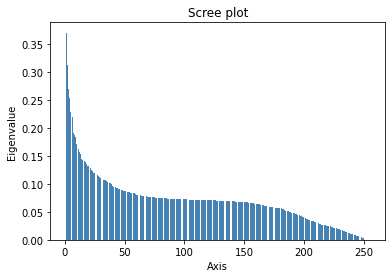

None


In [65]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
acm.fit(data.iloc[:127115,1:num_var_max].values)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [66]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [67]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=15)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
acm.fit(data.iloc[:127115,1:num_var_max].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [68]:
# dimension
coord.shape

(1192180, 15)

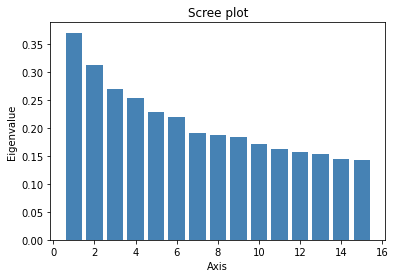

None


In [69]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [70]:
#coordonnées des colonnes
print(acm.col_topandas())

                     col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_01                0.303745       -0.199664       -0.211148   
TypeHabi_02               -0.137910        0.078707        0.088941   
TypeHabi_03                0.122199       -0.010173       -0.038724   
TypeHabi_04                0.078727       -1.065636       -1.803922   
GeoFaz_Scl_11             -0.138645       -0.005575       -0.087617   
...                             ...             ...             ...   
Potentiel_prenom_17       -1.320105        0.090332        0.899473   
Potentiel_prenom_18       -1.182690        0.075362        0.286507   
Potentiel_prenom_19       -1.281801        0.052114       -0.833528   
Potentiel_prenom_20       -1.174645        0.057272       -1.283870   
Potentiel_prenom_21        0.122916       -5.894422        0.417186   

                     col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_01                0.247493       -0.127000        0.242205   
TypeH

In [71]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


15
[[ 0.03324437 -0.0237759  -0.02707861 ... -0.00211514  0.02214265
  -0.04018564]
 [-0.01509404  0.00937241  0.01140621 ...  0.00162636 -0.00520022
   0.01211689]
 [ 0.01337452 -0.00121141 -0.0049661  ... -0.00417397 -0.01780262
   0.01635417]
 ...
 [-0.14029106  0.00620571 -0.10689556 ... -0.00430656 -0.20041651
  -0.11139973]
 [-0.12856302  0.00681995 -0.16464959 ... -0.26841431 -0.06683131
  -0.02224408]
 [ 0.01345298 -0.70190616  0.05350198 ... -0.02533906 -0.01216482
   0.00520516]]
                           0         1         2         3         4   \
TypeHabi_01          0.033244 -0.023776 -0.027079  0.032718 -0.017682   
TypeHabi_02         -0.015094  0.009372  0.011406 -0.012967  0.007439   
TypeHabi_03          0.013375 -0.001211 -0.004966  0.002939 -0.002679   
TypeHabi_04          0.008617 -0.126896 -0.231344 -0.011701 -0.258594   
GeoFaz_Scl_11       -0.015174 -0.000664 -0.011236  0.010562  0.012518   
...                       ...       ...       ...       ...       .

In [72]:
# affichafe des 10 premières lignes
print(coord[:2,:])


[[ 0.86585844 -0.23562583 -1.54494638  0.36875233 -1.58848612  0.32111693
   4.82360798  1.02242222 -0.58930332  0.19050679  0.36327062  0.4525547
   0.13149429 -0.71902619 -0.59435988]
 [ 0.58631339  0.05973386 -0.12572079  0.1360449   0.59304448  0.46186966
   0.06055677 -0.02802718  0.16498668 -0.35868261 -0.20906163  0.11183214
   0.13039718  0.38831965 -0.05117458]]


In [73]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1192180 non-null  object
 1   TypeHabi            1192180 non-null  object
 2   GeoFaz_Scl          1192180 non-null  object
 3   Anciennete          1192180 non-null  object
 4   Logement_prix_m2    1192180 non-null  object
 5   Mediane_RFR         1192180 non-null  object
 6   Sexe                1192180 non-null  object
 7   Prenom_Phase_scl_H  1192180 non-null  object
 8   Prenom_Phase_scl_F  1192180 non-null  object
 9   Age_H               1192180 non-null  object
 10  Age_F               1192180 non-null  object
 11  Affinite_1          1192180 non-null  object
 12  Affinite_2          1192180 non-null  object
 13  Prenom_effectif     1192180 non-null  object
 14  Potentiel_prenom    1192180 non-null  object
 15  Top_mon             99296 non-nu

In [74]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable Top_mon
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1] ): #avant 10
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable Top_mon

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1]): # avant 10
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["Top_mon"] = dfff["Top_mon"].replace(1.0, '1')
    dfff["Top_mon"] = dfff["Top_mon"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99296 entries, 0 to 99295
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IDENT    99296 non-null  object 
 1   0        99296 non-null  float64
 2   1        99296 non-null  float64
 3   2        99296 non-null  float64
 4   3        99296 non-null  float64
 5   4        99296 non-null  float64
 6   5        99296 non-null  float64
 7   6        99296 non-null  float64
 8   7        99296 non-null  float64
 9   8        99296 non-null  float64
 10  9        99296 non-null  float64
 11  10       99296 non-null  float64
 12  11       99296 non-null  float64
 13  12       99296 non-null  float64
 14  13       99296 non-null  float64
 15  14       99296 non-null  float64
 16  Top_mon  99296 non-null  int64  
dtypes: float64(15), int64(1), object(1)
memory usage: 13.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 17 co

In [75]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


In [76]:
#data_coord_nan.shape
#train_X_s.shape

In [77]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting :
# Résultat du traitement sur le train set (under-sampling et over-sampling)
#abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
#abc_np = abc_test.to_numpy(dtype="Int64")

#X_resampled = abc_np[:,:-1]
#y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [78]:

# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks()
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE()
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))

'''
# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
'''

Sans aucun traitement sur le train set :  (array([1, 2]), array([21397, 58039]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Après under-sampling :  (array([1, 2]), array([21397, 50605]))
Après over-smapling :  (array([1, 2]), array([50605, 50605]))


'\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [79]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.001,0.01]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

test set : 
[[3172 2159]
 [5994 8535]]
              precision    recall  f1-score   support

           1       0.35      0.60      0.44      5331
           2       0.80      0.59      0.68     14529

    accuracy                           0.59     19860
   macro avg       0.57      0.59      0.56     19860
weighted avg       0.68      0.59      0.61     19860

train set : 
[[29221 21384]
 [19820 30785]]
              precision    recall  f1-score   support

           1       0.60      0.58      0.59     50605
           2       0.59      0.61      0.60     50605

    accuracy                           0.59    101210
   macro avg       0.59      0.59      0.59    101210
weighted avg       0.59      0.59      0.59    101210



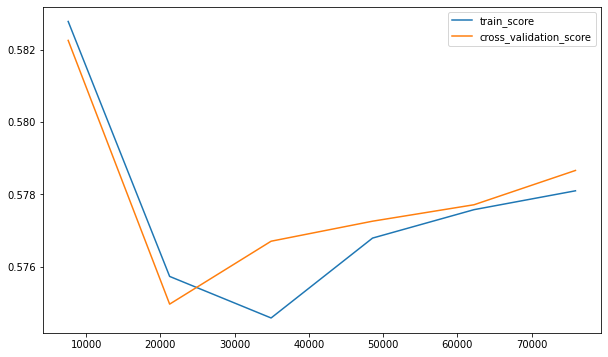

In [80]:
final_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(final_model_ADL, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "recall", plot=True)

In [81]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["Top_mon"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [82]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_01,-0.120990
TypeHabi_02,0.052431
TypeHabi_03,-0.033406
TypeHabi_04,-0.364314
GeoFaz_Scl_11,-0.037456
...,...
Potentiel_prenom_17,-0.041190
Potentiel_prenom_18,-0.067725
Potentiel_prenom_19,-0.095912
Potentiel_prenom_20,-0.112074


In [83]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model = final_model_ADL, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ACM_ADL_15.xlsx")

                    IDENT     PROBA
25518  000255190010343102  0.219254
83925  000839260010505522  0.219569
22808  000228090010339331  0.220280
87010  000870110010521170  0.222097
33930  000339310010358373  0.222666
...                   ...       ...
30193  000301940010350422  0.838576
2071   000020720010027021  0.838576
52881  000528820010378680  0.839833
14987  000149880010262185  0.839833
87863  000878640010522857  0.842483

[99296 rows x 2 columns]
0.804073    49
0.778021    28
0.623429    24
0.797643    19
0.705472    19
            ..
0.500953     1
0.467163     1
0.598653     1
0.477123     1
0.437110     1
Name: PROBA, Length: 96552, dtype: int64
                PROBA
25518  (0.218, 0.311]
83925  (0.218, 0.311]
22808  (0.218, 0.311]
87010  (0.218, 0.311]
33930  (0.218, 0.311]
...               ...
30193  (0.686, 0.842]
2071   (0.686, 0.842]
52881  (0.686, 0.842]
14987  (0.686, 0.842]
87863  (0.686, 0.842]

[99296 rows x 1 columns]
Top_mon            1     2  TOTAL
TRANCHES    

In [84]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADL_15.xlsx")

                      IDENT     PROBA
584426   004851310220026664  0.215555
309287   002099920120007261  0.216080
504732   004054370190020996  0.216114
427186   003278910140000070  0.216124
631816   005325210250004600  0.216124
...                     ...       ...
1091220  009919250370008388  0.841243
352009   002527140120049983  0.841243
1093864  009945690370011032  0.841243
1094472  009951770370011640  0.842483
895764   007964690340001932  0.843961

[1092884 rows x 2 columns]
0.705472    303
0.797643    229
0.782962    223
0.778021    222
0.780706    214
           ... 
0.445012      1
0.663201      1
0.396855      1
0.504211      1
0.454321      1
Name: PROBA, Length: 838236, dtype: int64
                  PROBA
584426   (0.215, 0.304]
309287   (0.215, 0.304]
504732   (0.215, 0.304]
427186   (0.215, 0.304]
631816   (0.215, 0.304]
...                 ...
1091220  (0.695, 0.844]
352009   (0.695, 0.844]
1093864  (0.695, 0.844]
1094472  (0.695, 0.844]
895764   (0.695, 0.844]

[1092884 

In [85]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)


test set : 
[[ 1805  3526]
 [ 2964 11565]]
              precision    recall  f1-score   support

           1       0.38      0.34      0.36      5331
           2       0.77      0.80      0.78     14529

    accuracy                           0.67     19860
   macro avg       0.57      0.57      0.57     19860
weighted avg       0.66      0.67      0.67     19860

train set : 
[[16755 33850]
 [ 9629 40976]]
              precision    recall  f1-score   support

           1       0.64      0.33      0.44     50605
           2       0.55      0.81      0.65     50605

    accuracy                           0.57    101210
   macro avg       0.59      0.57      0.54    101210
weighted avg       0.59      0.57      0.54    101210

GRAPHIQUE NON DEMANDE


In [86]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model =model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ACM_ADQ_15.xlsx")

                    IDENT     PROBA
29349  000293500010349327  0.003076
71553  000715540010405567  0.003334
15120  000151210010262361  0.005284
31093  000310940010351666  0.005618
50732  000507330010376221  0.005728
...                   ...       ...
20249  000202500010334666  1.000000
20105  000201060010333603  1.000000
20059  000200600010331542  1.000000
52981  000529820010378797  1.000000
0      000000010010000001  1.000000

[99296 rows x 2 columns]
1.000000    179
1.000000     49
0.999997     28
0.970728     24
0.999998     19
           ... 
0.183630      1
0.865040      1
0.459323      1
0.598467      1
0.042233      1
Name: PROBA, Length: 96393, dtype: int64
                   PROBA
29349  (0.00208, 0.0496]
71553  (0.00208, 0.0496]
15120  (0.00208, 0.0496]
31093  (0.00208, 0.0496]
50732  (0.00208, 0.0496]
...                  ...
20249       (0.987, 1.0]
20105       (0.987, 1.0]
20059       (0.987, 1.0]
52981       (0.987, 1.0]
0           (0.987, 1.0]

[99296 rows x 1 columns]

In [87]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADQ_15.xlsx")

                      IDENT     PROBA
630614   005313190250003398  0.001621
1093572  009942770370010740  0.001808
258563   001592680080002554  0.001834
537849   004385540200004109  0.002105
538266   004389710200004526  0.002157
...                     ...       ...
1093493  009941980370010661  1.000000
229276   001299810050069971  1.000000
1100963  010016680370018131  1.000000
402090   003027950130050074  1.000000
414531   003152360130062515  1.000000

[1092884 rows x 2 columns]
1.000000    3047
0.993407     303
0.999998     229
0.998860     223
0.999997     222
            ... 
0.061365       1
0.273856       1
0.728278       1
0.517373       1
0.474190       1
Name: PROBA, Length: 836894, dtype: int64
                                   PROBA
630614   (0.0006199999999999999, 0.0481]
1093572  (0.0006199999999999999, 0.0481]
258563   (0.0006199999999999999, 0.0481]
537849   (0.0006199999999999999, 0.0481]
538266   (0.0006199999999999999, 0.0481]
...                                  ...


In [88]:
###############################################################################
###############################################################################

In [89]:
# SANS UNDER-SAMPLING ET OVER-SAMPLING

print("ADL test sans under-sampling et over_sampling")
test_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADL, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

print("ADQ test sans under-sampling et over_sampling")
test_model_ADQ = QuadraticDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADQ, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

vingtiles(model =test_model_ADQ, data_orig = data_coord_nan, affichage=True,
          save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")


ADL test sans under-sampling et over_sampling
test set : 
[[  362  4969]
 [  304 14225]]
              precision    recall  f1-score   support

           1       0.54      0.07      0.12      5331
           2       0.74      0.98      0.84     14529

    accuracy                           0.73     19860
   macro avg       0.64      0.52      0.48     19860
weighted avg       0.69      0.73      0.65     19860

train set : 
[[ 1333 20064]
 [ 1059 56980]]
              precision    recall  f1-score   support

           1       0.56      0.06      0.11     21397
           2       0.74      0.98      0.84     58039

    accuracy                           0.73     79436
   macro avg       0.65      0.52      0.48     79436
weighted avg       0.69      0.73      0.65     79436

GRAPHIQUE NON DEMANDE
ADQ test sans under-sampling et over_sampling
test set : 
[[ 1034  4297]
 [ 1465 13064]]
              precision    recall  f1-score   support

           1       0.41      0.19      0.26    

In [ ]:
#################################################################################
#################################################################################

In [90]:
import warnings
warnings.filterwarnings("ignore")

In [91]:
from scipy.stats import shapiro

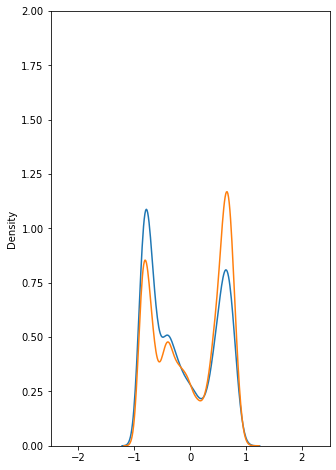

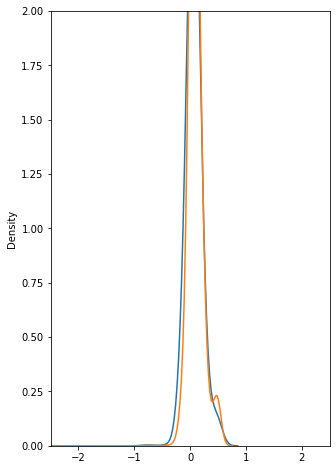

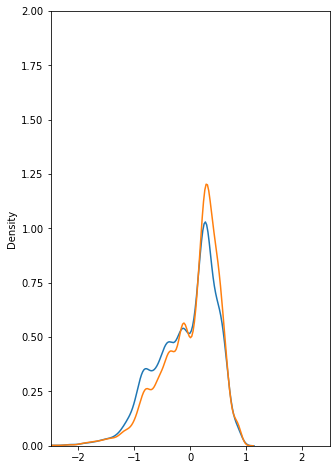

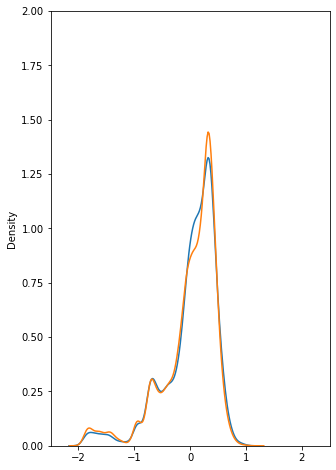

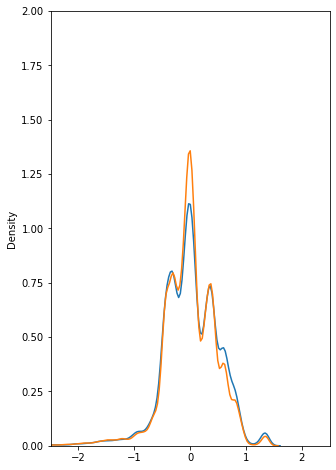

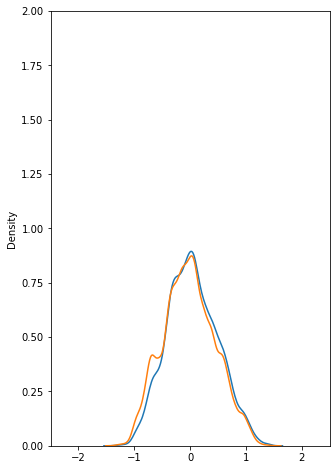

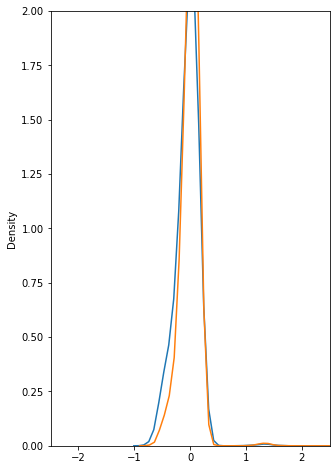

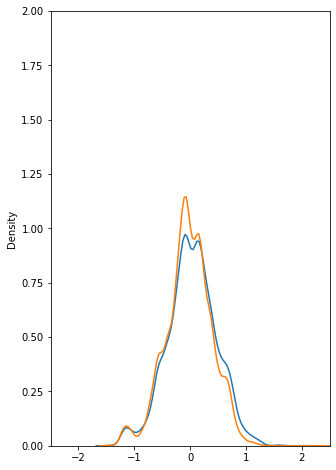

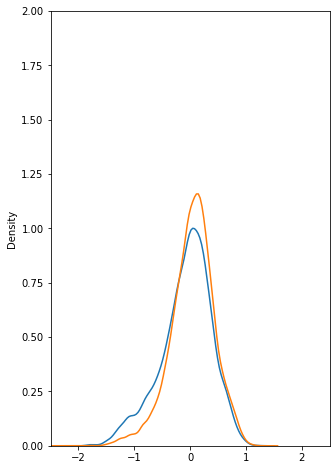

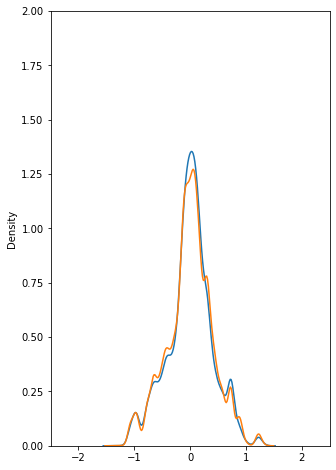

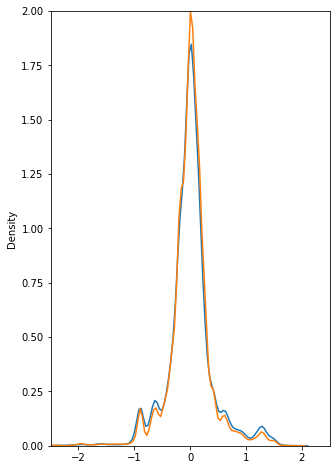

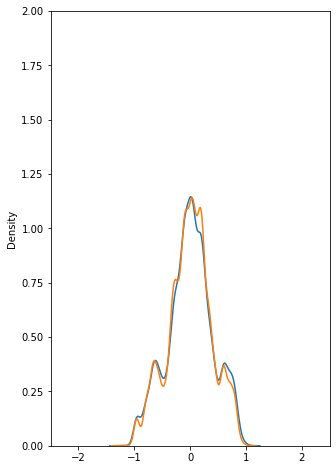

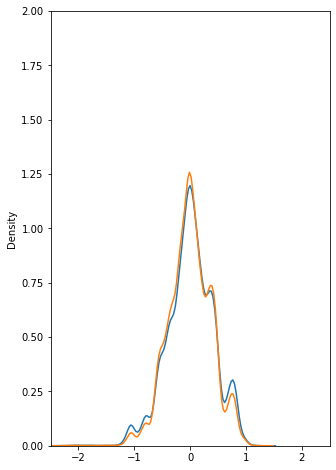

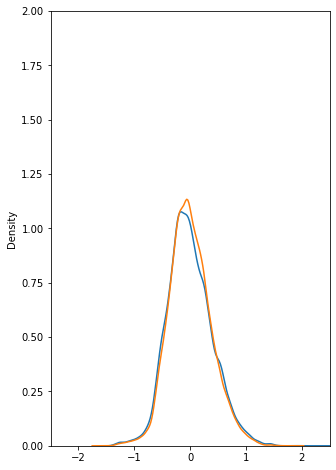

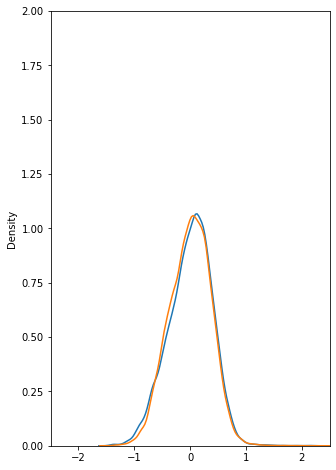

In [93]:

for i in range(0,15):
    plt.figure(figsize=(5,8))
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,i],hist=False) 
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,i],hist=False) 
    plt.xlim((-2.5,2.5))
    plt.ylim((0,2))


In [96]:
for j in range(15):
    print( shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,j]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j]) )

(0.8889386653900146, 0.0) (0.88752681016922, 0.0)
(0.33572298288345337, 0.0) (0.3221573829650879, 0.0)
(0.9529616832733154, 0.0) (0.9291819334030151, 0.0)
(0.8717105388641357, 0.0) (0.861024022102356, 0.0)
(0.95638507604599, 0.0) (0.9423134922981262, 0.0)
(0.9959754347801208, 6.040618565258718e-26) (0.9951214790344238, 7.894775418159587e-41)
(0.2060166597366333, 0.0) (0.23741638660430908, 0.0)
(0.949048638343811, 0.0) (0.9674699902534485, 0.0)
(0.948469877243042, 0.0) (0.9614996314048767, 0.0)
(0.9854901432991028, 9.80908925027372e-45) (0.9900328516960144, 0.0)
(0.8798614144325256, 0.0) (0.8598746061325073, 0.0)
(0.9900939464569092, 1.3937046878167945e-38) (0.9910640716552734, 0.0)
(0.9853678941726685, 7.006492321624085e-45) (0.9859757423400879, 0.0)
(0.9913292527198792, 1.508155700654167e-36) (0.9938042163848877, 8.407790785948902e-45)
(0.9881532788276672, 2.094801074319169e-41) (0.9904729127883911, 0.0)


In [97]:
shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,:]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,:])

((0.8687389492988586, 0.0), (0.9115259051322937, 0.0))

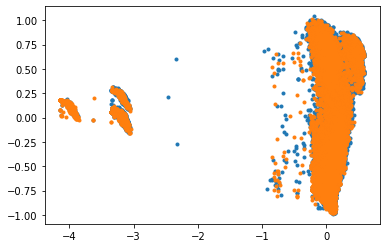

In [98]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,0],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,0],".")

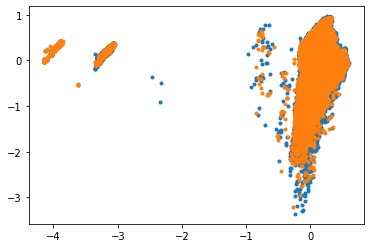

In [99]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

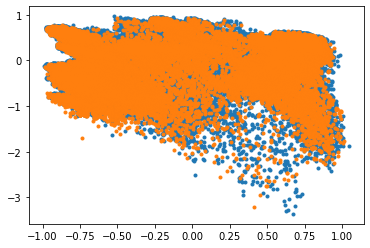

In [100]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,0], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,0], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

In [101]:
for j in range(15):#23456
    hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j])
    
    q_low = hhh.quantile(0.05)
    q_hi  = hhh.quantile(0.95)
    df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]

    print(shapiro(df_filtered.dropna()))


(0.8826243877410889, 0.0)
(0.9888412356376648, 0.0)
(0.9318932294845581, 0.0)
(0.9116094708442688, 0.0)
(0.979480504989624, 0.0)
(0.9826248288154602, 0.0)
(0.9731096029281616, 0.0)
(0.9884598851203918, 0.0)
(0.9880431294441223, 0.0)
(0.9888715744018555, 0.0)
(0.9916458129882812, 0.0)
(0.9882144927978516, 0.0)
(0.9854512810707092, 0.0)
(0.9830330610275269, 0.0)
(0.9786491394042969, 0.0)


(26728, 1)
(26728, 1)


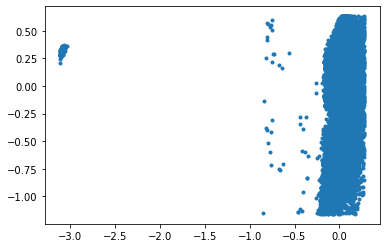

In [102]:
hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1])
q_low = hhh.quantile(0.03)
q_hi  = hhh.quantile(0.95)
df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]
print(df_filtered.shape)

hhh_2 = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,2])
q_low_2 = hhh_2.quantile(0.03)
q_hi_2  = hhh_2.quantile(0.95)
df_filtered_2 = hhh_2[(hhh_2 < q_hi_2) & (hhh_2 > q_low_2)]
print(df_filtered_2.shape)

plt.plot(df_filtered.iloc[:,0], df_filtered_2.iloc[:,0], '.')

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


In [ ]:
###########################################################################################################
#  PIPELINE

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
disqual =  Pipeline([("acm", MCA(var_labels = data.columns[1:num_var_max], )),("adl", LinearDiscriminantAnalysis())])

In [ ]:
disqual.fit(data.iloc[:127115, 1:-1].values, data.iloc[:127115, num_var_max] )



In [ ]:
#accès à l'ACM, nombre de composants
print(disqual.named_steps["acm"].n_components_)


In [ ]:
#afficher les valeurs propres
disqual.named_steps["acm"].plot_eigenvalues()


In [ ]:
#coefs. de la fonction score
print(disqual.named_steps["adl"].coef_)


In [ ]:
#prediction
pVote = disqual.predict(vote_test.iloc[:,:-1].values)
print(numpy.unique(pVote,return_counts=True))


In [ ]:
#nombres de facteurs à tester
parametres = [{"acm__n_components":[1,2,5,10,15,20,25,30,32]}]

In [ ]:
1771/4964

0.35676873489121674